In [1]:
import sys  
sys.path.insert(0, 'C:\\Users\\espebh\\Documents\\Thesis\\code_ver2')
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
from helpers import m
from helpers.prob_utils import prob_random_clsf
from helpers.sine_fitting_utils import fit_sine


In [2]:
tracker_path = 'C:\\Users\\espebh\\Documents\\Thesis\\data\\Results\\Results from full pipeline in tank 6\\salmon_jaw_distances_061022_t6_c1_f2000\\trackers'
out_path = 'C:\\Users\\espebh\\Documents\\Thesis\\data\\frequency_dicts'
dict_name = "downbreathing_frequencies_" + "_".join(tracker_path.split('\\')[-2].split('_')[3:])
fish_names = m.FISH_NAMES_T6
classes_to_fish_map = m.CLASSES_TO_FISH_MAP_T6
print(dict_name)

downbreathing_frequencies_061022_t6_c1_f2000


In [3]:
# This function removes time series points with obvious erroneous detections.
# LABEL_NAMES = ['ljaw', 'ujaw', 'eye', 'rjaw', 'rpec', 'head_body_intercept', 'dfin']
# keep_jaw_indices: Indices of the time series that contain correct jaw classifications. [0, 1, 2, 6, 7, ...].
# keep_cl_indices: Indices of the time series that contain correct rpec, head_body_intercept, dfin and eye detections. Referencing the correct jaw indices, hence to get the correct class points from the initial time series,
# the correct indexing would be ts[keep_jaw_indices][keep_cl_indices]. 
# keypoints: Keypoint detections from keypoint rcnn saved in the trackers. [np.array(7,2), np.array(7,2), ...]

def review_kp_positions(keypoints, debug = False):
    keep_jaw_indices = []
    keep_cl_indices = []
    for i in range(len(keypoints)):
        kps = keypoints[i]

        # find swimming direction based on relative location of head-body-intercept and dorsal fin.
        if kps[5][0] >= kps[6][0]:
            dir = 'sr'
        elif kps[5][0] < kps[6][0]:
            dir = 'sl'

        # Check if the salmon is swimming towards the camera based on relative location of eye and head-body-intercept.
        if dir == 'sr' and kps[2][0] < kps[5][0]:
            dir = 'front'
            if debug: print('Salmon at index ', i, ' is recorded from the front')
        elif dir == 'sl' and kps[2][0] > kps[5][0]:
            dir = 'front'
            if debug: print('Salmon at index ', i, ' is recorded from the front')

        # Examine whether the vertical keypoint position is erroneous
        # 1. Check if ujaw is lower than ljaw.
        # 2. Check if ljaw is clearly above the eye
        # 3. Check if dfin is above rpec
        ujaw_wrong_ver_pos = kps[1][1] > kps[0][1]
        ljaw_wrong_ver_pos = kps[2][1] - kps[0][1] > 5
        rpec_wrong_ver_pos = kps[5][1] > kps[4][1]

        # Examine whether the horizontal keypoint position is erroneous.
        # The jaws are erroneous if any keypoints are more aneterior on the fish than the jaw detections.
        # The classifications additionally requires correct horizontal placement of eye, rpec and dfin.
        if dir == 'sl':
            ljaw_wrong_hor_pos = kps[0][0] >= kps[2][0] or kps[0][0] >= kps[3][0] or kps[0][0] >= kps[4][0] or kps[0][0] >= kps[5][0] or kps[0][0] >= kps[6][0]
            ujaw_wrong_hor_pos = kps[1][0] >= kps[2][0] or kps[1][0] >= kps[3][0] or kps[1][0] >= kps[4][0] or kps[1][0] >= kps[5][0] or kps[1][0] >= kps[6][0]
            eye_wrong_hor_pos = kps[2][0] > kps[4][0] or kps[2][0] > kps[6][0]
            rpec_wrong_hor_pos = kps[4][0] > kps[6][0]
            hbi_wrong_hor_pos = kps[5][0] > kps[6][0]
        if dir == 'sr':
            ljaw_wrong_hor_pos = kps[0][0] <= kps[2][0] or kps[0][0] <= kps[3][0] or kps[0][0] <= kps[4][0] or kps[0][0] <= kps[5][0] or kps[0][0] <= kps[6][0]
            ujaw_wrong_hor_pos = kps[1][0] <= kps[2][0] or kps[1][0] <= kps[3][0] or kps[1][0] <= kps[4][0] or kps[1][0] <= kps[5][0] or kps[1][0] <= kps[6][0]
            eye_wrong_hor_pos = kps[2][0] < kps[4][0] or kps[2][0] < kps[6][0]
            rpec_wrong_hor_pos = kps[4][0] < kps[6][0]
            hbi_wrong_hor_pos = kps[5][0] < kps[6][0]

        # Flags to specify wheteher the current index should be removed from the timeseries
        idx_err_for_jaws = 0
        idx_err_for_cl = 0

        # Remove datapoint if the horizontal or vertical location is wrong
        if dir != 'front' and (ljaw_wrong_hor_pos or ujaw_wrong_hor_pos):
            idx_err_for_jaws = 1
            idx_err_for_cl = 1
            if debug: print('Wrong horizontal jaw positions at index ', i)
        if dir != 'front' and (eye_wrong_hor_pos or rpec_wrong_hor_pos or hbi_wrong_hor_pos):
            idx_err_for_cl = 1
            if debug: print('Wrong horizontal keypoint positions at index ', i)

        if ujaw_wrong_ver_pos or ljaw_wrong_ver_pos: 
            idx_err_for_jaws = 1
            idx_err_for_cl = 1
            if debug: print('Wrong vertical jaw positions at index ', i)
        if rpec_wrong_ver_pos:
            idx_err_for_cl = 1
            if debug: print('Wrong vertical keypoint positions at index ', i)

        # Remove datapoint if the upper jaw is further away from the eye in the y direction, than in the x direction
        # This is the case if the upper jaw is detected wrong.
        elif  np.linalg.norm(kps[2][0] - kps[1][0])/(np.linalg.norm(kps[2][1] - kps[1][1])+np.finfo(float).eps) < 1:
            idx_err_for_jaws = 1
            idx_err_for_cl = 1
            if debug: print('Upper jaw too far away from the eye at index ', i)

        if idx_err_for_jaws == 0:
            keep_jaw_indices.append(i)
        if dir != 'front' and idx_err_for_cl == 0:
            keep_cl_indices.append(len(keep_jaw_indices)-1)

    return keep_jaw_indices, keep_cl_indices


In [4]:
# Input: Trackers from a video sequence
# Output freq_dict: Dictionary with a list of frequensies for each individual fish. {'Aaron': [1.357659211812543, 1.3544284373646365, ...], 'Baasha': [...], ...}
# Output plot_dict: A dictionary with information that can be used to plot and debug the frequency extraction algorithm.

# fish_names: Alphabetically ordered names of the fish in the tank
# type: The mouth pose metric used. Can be 'euc' for euclidean distance, 'ang' for angular opening and 'wrp' for euclidean distance after homogenous transform.
# length_of_ts: The length of the timeseries that the jaw pose evolutions are cut into. One length_of_ts timeseries equals one frequency in freq_dict.
# advance_per_ts: The number of datapoints between the start of two consecutive time series.
# min_val_cls_cnt: The time series will only be accepted if more than min_val_cls_cnt*100 percent of the classifications are held by the most common fish.
# min_cls_cert: Let k be the largest class in a tracker, and prob be the probability of a random classifier finding more than k of one class for a given frame number. Then, prob must be lower than cls_cert for the tracker to be accepted.
# max_freq_std: If the frequency standard deviation of the final sine fitting is above max_freq_std, the time series is rejected.
# max_frame_diff_in_ts: The maximum frame count difference between the first and last point in a time series
# min_inl_cnt: The minimum number of inliers in a time series

def generate_frequency_dicts(trackers, 
                            fish_names,
                            classes_to_fish_map,
                            type = 'euc', 
                            length_of_ts = 100, 
                            advance_per_ts = 20,
                            min_val_cls_cnt = 1/3,
                            min_cls_cert = 0.01, 
                            max_freq_std = 0.05,
                            max_frame_diff_in_ts = 200,
                            min_inl_cnt = 55,
                            debug = False):

    # Define frequencies for line search
    test_freq = [0.8, 1.2, 1.6, 2, 2.4]

    # Define output dicts, one for storing information for plotting, one for storing frequency information
    plot_dicts = []
    freq_dict =  dict([(x,[]) for x in (fish_names)])

    # Iterate over all trackers
    for tracker in trackers:
        # Extract time and mouth opening lists from trackers
        x = np.array(tracker.frames).astype(int)/m.FRAMES_PER_SECOND
        if type == 'euc':
            y = np.array(tracker.full_dists)
        elif type == 'ang':
            y = np.array(tracker.ang_dists)
            y[y<-180] = y[y<-180]+360
            y[y>180] = y[y>180]-360
        elif type == 'wrp':
            y = np.array(tracker.warped_dists)

        # Remove if the data arrays are too short
        if len(x) < length_of_ts:
            continue
        
        # Remove points if the keypoint configuration is clearly erroneous
        keep_jaw_indices, keep_cl_indices = review_kp_positions(tracker.keypoints)
        x, y, cl= np.array(x)[keep_jaw_indices], np.array(y)[keep_jaw_indices], np.array(tracker.clses)[:,0].astype(int)[keep_jaw_indices]
        one_hot_cl = [False]*len(cl)
        for i in range(len(one_hot_cl)):
            if i in keep_cl_indices:
                one_hot_cl[i] = True

        # Remove if the data arrays are too short
        if len(x) < length_of_ts:
            continue
        
        # Make data arrays. Each data array have shape 4xlength_of_ts.
        data = np.stack([x, y, cl, one_hot_cl])
        split = []
        for i in range(0,data.shape[1],advance_per_ts):
            split.append(data[:,i:i+length_of_ts])
            
        # Iterate over all timeseries
        for d in split:
            # Early rejectance of short trackers
            if d.shape[1]<length_of_ts:
                continue

            # split the data array into individual arrays
            xs, ys, cl, one_hot_cl = d[0,:], d[1,:], d[2,:], d[3,:]

            # Fit sine
            b_inl_cnt = 0
            b_config = []
            for freq in test_freq:
                y_sine, popt, perr, inl = fit_sine(xs, ys, freq, thresh_gain = 1)
                if sum(inl) > b_inl_cnt and perr[0] < max_freq_std:
                    b_config = [y_sine, popt, perr, inl]
                    b_inl_cnt = sum(inl)
            if len(b_config) > 0:
                y_sine, popt, perr, inl = b_config
            else:
                if debug: print('Could not fit sinusoid for box', tracker.id)
                continue

            # Find the most common fish
            fish_cnt = []
            for fish in classes_to_fish_map:
                cnt = 0
                for c in fish:
                    cnt = cnt + list(np.array(cl)[one_hot_cl==True]).count(c)
                fish_cnt.append(cnt)
            fish_name = fish_names[np.argmax(np.array(fish_cnt))]
            num_frames_in_max_cl = np.max(np.array(fish_cnt))
            num_cl_pred = len(np.array(cl)[one_hot_cl==True])

            # Check rate of correct class predictions
            if prob_random_clsf(num_frames_in_max_cl, num_cl_pred, prob = 1/2) > min_cls_cert:
                if debug: print('Probability that ', fish_name, ' is picked at random is ', prob_random_clsf(num_frames_in_max_cl, num_cl_pred, prob = 1/2))
            # Check number of correct class predictions
            elif num_cl_pred < min_val_cls_cnt*length_of_ts:
                if debug: print('The number of accurate class predictions for ', fish_name, ' are ', num_cl_pred)
            # Check time difference between first and last frame
            elif xs[-1]-xs[0] > max_frame_diff_in_ts/m.FRAMES_PER_SECOND:
                if debug: print('The length between first and last frame are ', xs[-1]-xs[0], ' for box ', tracker.id)
            # Check number of inliers
            elif sum(inl) < min_inl_cnt:
                if debug: print('The number of inliers are ', sum(inl), ' for box ', tracker.id)
            # Store information in output dicts
            else:
                freq_dict[fish_name].append(popt[0])
                plot_dicts.append({ 'full_arr': np.stack([xs, ys]),
                            'sine_arr': np.stack([xs, y_sine]),
                            'inl_arr': np.stack(([xs[inl], ys[inl]])),
                            'name': fish_name,
                            'box': tracker.id,
                            'freq': popt[0],
                            'std': perr[0],
                            'amp': popt[1],
                            'rs': sum(perr),
                            'one_hot': one_hot_cl})

    return freq_dict, plot_dicts

In [5]:
tracker_names = list(sorted(os.listdir(tracker_path)))
plot_dict = dict([(x,[]) for x in (fish_names)])
downbreathing_dict ={'names': [], 'values': []}

#downbreathing_dict = []
l=0

for tracker_name in tracker_names:
    downbreathing_dict['names'].append(tracker_name)
    infile = open(os.path.join(tracker_path, tracker_name),'rb')
    trackers = pickle.load(infile)
    infile.close()
    freq_dict, _ = generate_frequency_dicts(trackers, fish_names, classes_to_fish_map, type='euc',  debug=False)
    downbreathing_dict['values'].append(freq_dict)
    print('Done with tracker ', tracker_name)
    #l=l+1
    #if l > 0:
    #    break


c:\Users\espebh\Documents\Thesis\code_ver2\dat_gen_th\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Done with tracker  061022_t6_c1_1tunc_s1_f_5000_7000_20235301038.pkl
Done with tracker  061022_t6_c1_1tunc_s2_f_5000_7000_20235301217.pkl
Done with tracker  061022_t6_c1_1tunc_s3_f_5000_7000_20235301352.pkl
Done with tracker  061022_t6_c1_1tunc_s4_f_5000_7000_20235301526.pkl
Done with tracker  061022_t6_c1_1tunc_s5_f_5000_7000_20235301656.pkl
Done with tracker  061022_t6_c1_1tunc_s6_f_5000_7000_20235301826.pkl
Done with tracker  061022_t6_c1_2t_s1_f_5000_7000_20235111336.pkl
Done with tracker  061022_t6_c1_2t_s2_f_5000_7000_2023511154.pkl
Done with tracker  061022_t6_c1_2t_s3_f_5000_7000_20235111634.pkl
Done with tracker  061022_t6_c1_2t_s4_f_5000_7000_2023511183.pkl
Done with tracker  061022_t6_c1_2t_s5_f_5000_7000_20235111929.pkl
Done with tracker  061022_t6_c1_2t_s6_f_5000_7000_20235112056.pkl
Done with tracker  061022_t6_c1_3t_s1_f_5000_7000_20235112223.pkl
Done with tracker  061022_t6_c1_3t_s2_f_5000_7000_20235112352.pkl
Done with tracker  061022_t6_c1_3t_s3_f_5000_7000_2023512122

In [6]:
# Save generated downbreathing data
db_data_file = open(os.path.join(out_path, dict_name + '.pkl'), 'wb')
pickle.dump(downbreathing_dict, db_data_file)
db_data_file.close()

c:\Users\espebh\Documents\Thesis\code_ver2\dat_gen_th\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\espebh\Documents\Thesis\code_ver2\dat_gen_th\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\espebh\Documents\Thesis\code_ver2\dat_gen_th\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\espebh\Documents\Thesis\code_ver2\dat_gen_th\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\espebh\Documents\Thesis\code_ver2\dat_gen_th\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype

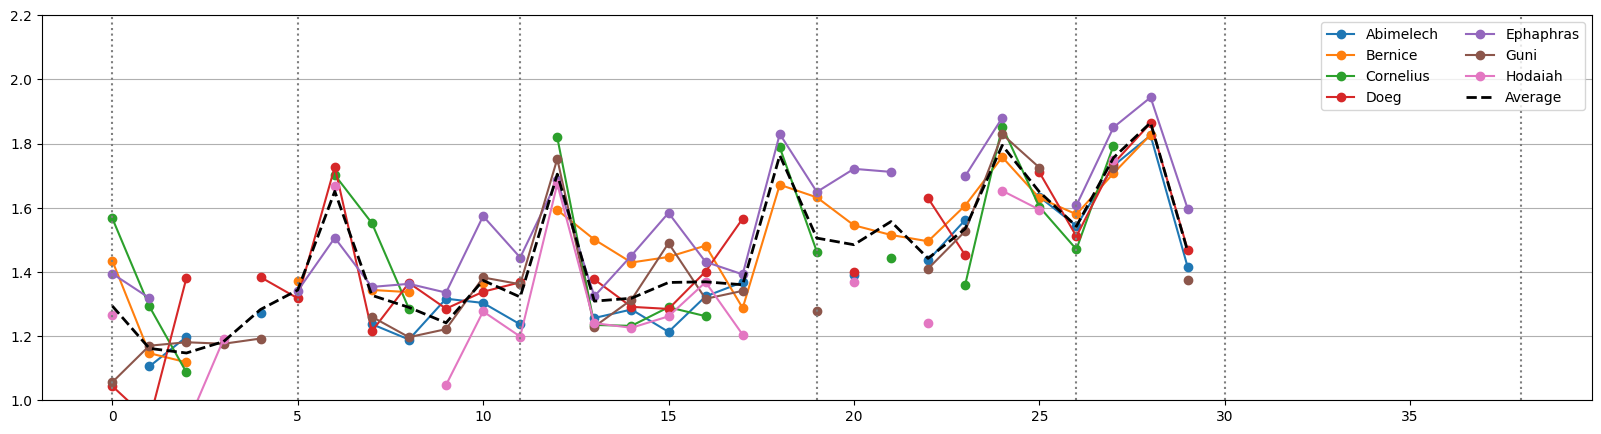

In [7]:
import matplotlib.colors as mcolors

# Load tracker
infile = open(os.path.join(out_path, dict_name + '.pkl'),'rb')
downbreathing_dict = pickle.load(infile)
downbreathing_dict = downbreathing_dict['values']
infile.close()

# Find data statistics from tracker
avgs = []
full_db_freq_dict = dict([(x,[]) for x in (fish_names)])
full_db_std_dict = dict([(x,[]) for x in (fish_names)])
for freq_dict in downbreathing_dict:
    avg = []
    for fish_name in freq_dict.keys():
        med = np.median(freq_dict[fish_name])
        std = np.std(freq_dict[fish_name])
        if len(freq_dict[fish_name]) <= 2:
            med = math.nan
            std = math.nan
        if not math.isnan(med):
            avg.append(med)
        full_db_freq_dict[fish_name].append(med)
        full_db_std_dict[fish_name].append(std)
    if len(avg)>=2:
        avgs.append(np.average(avg))
    else:
        avgs.append(math.nan)

# Plot
times_of_camera_ins = [0, 5, 11, 19, 26, 30, 38]
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
for i in range(len(m.FISH_NAMES_T5)):
    plt.plot(np.array(range(len(full_db_freq_dict[fish_names[i]])))[:], np.array(full_db_freq_dict[fish_names[i]])[:], '-o', label = fish_names[i])
for d in times_of_camera_ins:
    plt.axvline(d, linestyle = ':', color = mcolors.TABLEAU_COLORS['tab:gray'])
    
plt.plot(avgs, linestyle='--', linewidth = 2, color = 'k', label = 'Average')
plt.legend(ncols = 2)
plt.ylim(1, 2.2)
plt.grid(visible=True, axis='y')
plt.show()
